### ВЫБИРАЕМ АВТО ВЫГОДНО

Вы работаете в компании, которая занимается продажей автомобилей с пробегом в Москве. 

Основная задача компании и её менеджеров — максимально быстро находить выгодные предложения (проще говоря, купить ниже рынка, а продать дороже рынка). 

Руководство компании просит вашу команду создать модель, которая будет предсказывать стоимость автомобиля по его характеристикам.

Если такая модель будет работать хорошо, то вы сможете быстро выявлять выгодные предложения (когда желаемая цена продавца ниже предсказанной рыночной цены). Это значительно ускорит работу менеджеров и повысит прибыль компании.

МЕТРИКА

MAPE  (Mean Percentage Absolute Error) расшифровывается выражение как средняя абсолютная ошибка в процентах.



In [117]:
import numpy as np 
import pandas as pd 
import sys
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor, GradientBoostingClassifier, RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import ExtraTreesRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from xgboost.sklearn import XGBRegressor
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import time 
from tqdm import tqdm
import copy
from sklearn.base import clone
from socket import socket

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats.distributions import randint


In [7]:
# Определяем функции

# Функция для определения границ выбросов
def get_outliners(column):
    koeff = 1.5
    median = column.median()
    quan25 = column.quantile(0.25)
    quan75 = column.quantile(0.75)
    IQR = quan75 - quan25
    left = quan25 - koeff*IQR,
    right = quan75 + koeff*IQR
    print(f"Границы выбросов для признака '{column.name}': [{left}, {right}]")
    return(left, right)


# рассчёт поправочного коэффициента в зависимости от изменение курса доллара
prev_rate = 77.9241
curr_rate = 73.6007  # 21/05/21
rate_coeff = prev_rate/curr_rate
print(f'поправочный коэффициент {rate_coeff}')


# функция обучения модели и вывода MAPE
# is_log - передавать значение True, если y_train прологарифмирован
def learn_model(model, X_train, X_test, y_train, y_test, is_log=False):
    model.fit(X_train, y_train)
    y_pred = []
    if is_log:
        y_pred = np.round(np.exp(model.predict(X_test))).astype(int)
    else:
        y_pred = model.predict(X_test)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    print(f"Средняя абсолютная ошибка в процентах: {mape*100:0.2f}%")
    return mape

# функция сохранения результатов в списке results


def safe_results(results, model_name, mape, test_prediction, sabmission):
    results[model_name] = {
        'mape': mape, 'test_prediction': test_prediction, 'submission': sabmission}

# функция получения предсказания. функция учитывает изменение курса доллара между временем парсинга обучаещего
# и тестового датасета через rate_coeff


def model_prediction(model, X_test, test_df, is_log=False):
    predict_test = []
    predict_submission = []
    if is_log:
        predict_test = np.round(np.exp(model.predict(X_test)), -3).astype(int)
        predict_submission = np.round(
            np.exp(model.predict(test_df))/rate_coeff, -3).astype(int)
    else:
        predict_test = np.round(model.predict(X_test), -3)
        predict_submission = np.round(model.predict(test_df)/rate_coeff, -3)

    return predict_test, predict_submission

поправочный коэффициент 1.0587412891453476


In [8]:
# фиксируем RANDOM_SEED, чтобы эксперимент был воспроизводим!
RANDOM_SEED = 42

In [9]:
# подгружаем датасет и смотрим на количество пропусков, убеждаемся, что пропусков нет
df = pd.read_csv('/Users/dianaulianova/Desktop/data/test/preproc.csv')
df.isnull().sum()

price                   0
body_type               0
color                   0
engine_displacement     0
engine_power            0
fuel_type               0
mileage                 0
vehicle_transmission    0
owners                  0
vehicle_pasport         0
wheel                   0
condition               0
brand                   0
model_name              0
description             0
model_date              0
test                    0
number_of_doors         0
dtype: int64

In [10]:
df.head(5)

,price,body_type,color,engine_displacement,engine_power,fuel_type,mileage,vehicle_transmission,owners,vehicle_pasport,wheel,condition,brand,model_name,description,model_date,test,number_of_doors
0,95000,седан,пурпурный,1800,113,none,385000,механическая,3,дубликат,левый,Не требует ремонта,bmw,3ER,9,1992,0,4
1,7990000,купе,серый,1500,231,none,17979,автоматическая,3,оригинал,левый,Не требует ремонта,bmw,I8,0,2018,0,2
2,1090000,компактвэн,синий,1500,116,none,116000,механическая,1,оригинал,левый,Не требует ремонта,bmw,2GRANDTOURER,0,2016,0,4
3,3000000,родстер,чёрный,1800,115,none,100000,механическая,3,дубликат,левый,Не требует ремонта,bmw,Z3,0,1997,0,4
4,469000,внедорожник,чёрный,2000,177,none,235000,автоматическая,2,оригинал,левый,Не требует ремонта,bmw,X3,0,2007,0,4


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135986 entries, 0 to 135985
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   price                 135986 non-null  int64 
 1   body_type             135986 non-null  object
 2   color                 135986 non-null  object
 3   engine_displacement   135986 non-null  int64 
 4   engine_power          135986 non-null  int64 
 5   fuel_type             135986 non-null  object
 6   mileage               135986 non-null  int64 
 7   vehicle_transmission  135986 non-null  object
 8   owners                135986 non-null  int64 
 9   vehicle_pasport       135986 non-null  object
 10  wheel                 135986 non-null  object
 11  condition             135986 non-null  object
 12  brand                 135986 non-null  object
 13  model_name            135986 non-null  object
 14  description           135986 non-null  int64 
 15  model_date       

In [12]:
df.columns

Index(['price', 'body_type', 'color', 'engine_displacement', 'engine_power',
       'fuel_type', 'mileage', 'vehicle_transmission', 'owners',
       'vehicle_pasport', 'wheel', 'condition', 'brand', 'model_name',
       'description', 'model_date', 'test', 'number_of_doors'],
      dtype='object')

In [13]:
col_list = ['price', 'body_type', 'color', 'engine_displacement', 'engine_power',
       'fuel_type', 'mileage', 'vehicle_transmission', 'owners',
       'vehicle_pasport', 'wheel', 'condition', 'brand', 'model_name',
       'description', 'model_date', 'test', 'number_of_doors']

In [14]:
# посмотрим на многообразие уникальных значений
for col in col_list:
    print('\nпризнак:', col)
    print(df[col].value_counts())


признак: price
0          34686
650000      1246
450000      1156
750000      1143
550000      1095
           ...  
509897         1
354499         1
3248000        1
1216700        1
288888         1
Name: price, Length: 6585, dtype: int64

признак: body_type
внедорожник      51045
седан            49996
хэтчбек          10920
лифтбек           8223
универсал         4870
минивэн           3599
компактвэн        2440
купе              2209
пикап             1259
купе-хардтоп       531
фургон             371
родстер            211
кабриолет          201
микровэн            87
седан-хардтоп       12
лимузин              9
тарга                2
фастбек              1
Name: body_type, dtype: int64

признак: color
чёрный         40716
белый          29179
серебристый    17330
серый          17183
синий          10761
коричневый      5495
красный         5399
зелёный         2455
бежевый         2277
голубой         1685
золотистый      1034
пурпурный        780
фиолетовый       676
жёлт

In [15]:
# мы имеем одинаковое значение признака condition для всего датасета, удалим его
df = df.drop(columns='condition', axis=1)
df = df.drop(columns='fuel_type', axis=1)

In [16]:
df

,price,body_type,color,engine_displacement,engine_power,mileage,vehicle_transmission,owners,vehicle_pasport,wheel,brand,model_name,description,model_date,test,number_of_doors
0,95000,седан,пурпурный,1800,113,385000,механическая,3,дубликат,левый,bmw,3ER,9,1992,0,4
1,7990000,купе,серый,1500,231,17979,автоматическая,3,оригинал,левый,bmw,I8,0,2018,0,2
2,1090000,компактвэн,синий,1500,116,116000,механическая,1,оригинал,левый,bmw,2GRANDTOURER,0,2016,0,4
3,3000000,родстер,чёрный,1800,115,100000,механическая,3,дубликат,левый,bmw,Z3,0,1997,0,4
4,469000,внедорожник,чёрный,2000,177,235000,автоматическая,2,оригинал,левый,bmw,X3,0,2007,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135981,0,седан,коричневый,1600,136,115000,автоматическая,3,оригинал,левый,bmw,3ER,0,2011,1,4
135982,0,седан,чёрный,2000,190,98000,автоматическая,1,оригинал,левый,bmw,5ER,0,2016,1,4
135983,0,седан,серый,2500,170,360000,автоматическая,3,дубликат,левый,bmw,5ER,0,1995,1,4
135984,0,внедорожник,коричневый,2000,184,90500,автоматическая,2,оригинал,левый,bmw,X1,0,2012,1,5


In [17]:
# распределение признаков по типам
# категориальные (тип кузова, цвет, тип коробки передач, птс, тип руля, бренд, марка модели, количество дверей):
cat_col = ['body_type', 'color', 'vehicle_transmission',
           'vehicle_pasport', 'wheel', 'brand', 'model_name', 'number_of_doors']
# бинарные:
bin_col = ['test']
# количественные (объем двигателя, мощность двигателя, пробег, количество владельцев, описание, год модели):
num_col = ['engine_displacement', 'engine_power',
           'mileage', 'owners', 'description', 'model_date']
# целевая переменная, количественный тип:
target_col = ['price']

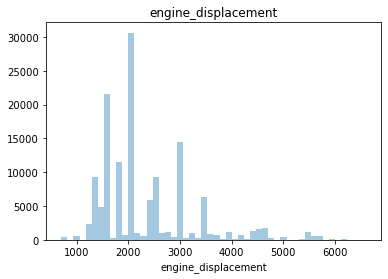

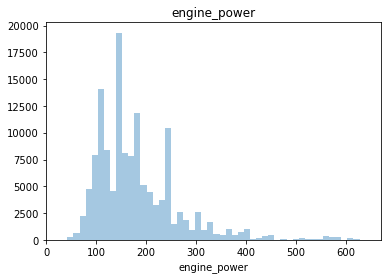

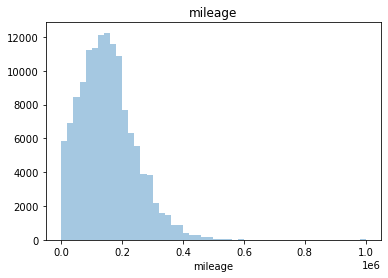

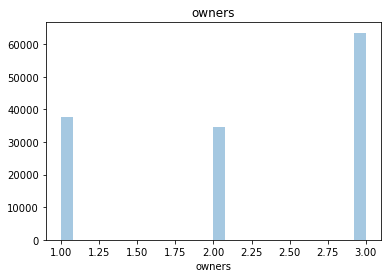

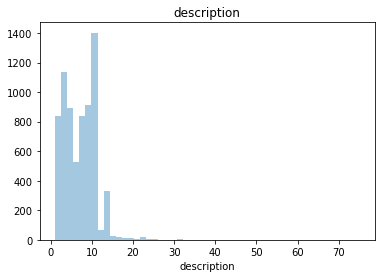

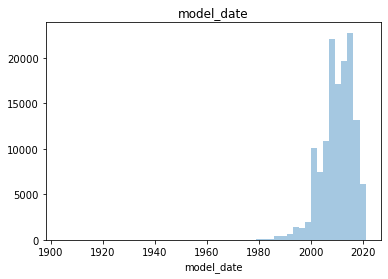

In [18]:
for i in num_col:
    plt.figure()
    sns.distplot(df[i][df[i] > 0].dropna(), kde=False, rug=False)
    plt.title(i)
    plt.show()

In [19]:
# числовые признаки распределены нормально

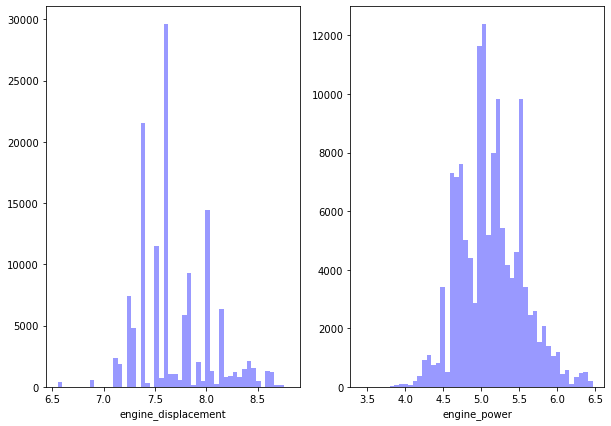

In [20]:
# попробуем прологарифмировать пару признаков, посмотрим на получившееся распределение
df_copy = df.copy()
cols = ['engine_displacement', 'engine_power']
fig, axes = plt.subplots(1, len(cols), figsize=(10, 7))
for i, col in enumerate(cols):
    df_copy[col] = np.log(df_copy[col] + 1)
    sns.distplot(df_copy[col][df_copy[col] > 0].dropna(),
                 ax=axes.flat[i], kde=False, rug=False, color="b")

логарифмирование признаков позволило улучшить распределение

In [21]:
cols = ['engine_displacement', 'engine_power']
for i, col in enumerate(cols):
    df[col] = np.log(df[col] + 1)

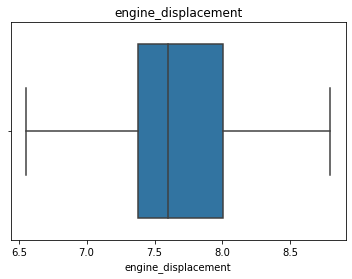

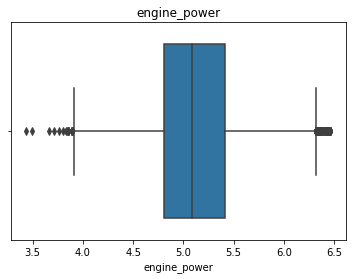

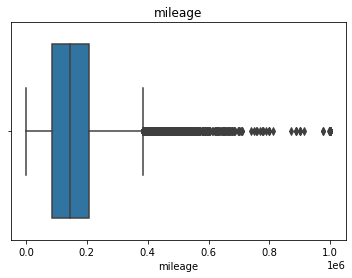

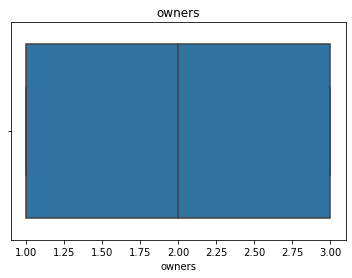

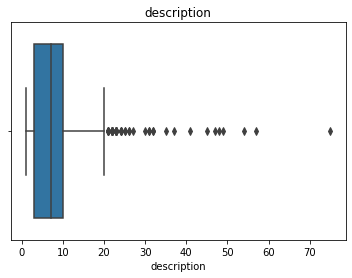

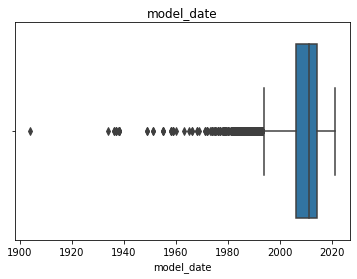

In [22]:
# Для числовых переменных построим Боксплоты
for i in num_col:
    plt.figure()
    sns.boxplot(df[i][df[i] > 0].dropna())
    plt.title(i)
    plt.show()

In [137]:
# на боксплотах отмечаем, что большое количество выбросов имеют значения признака год выпуска, но эти значения нам пригодятся, удалять их не будем, так как на рынке продаются редкие раритетные авто

In [23]:
for i in num_col:
    left, right = get_outliners(df[i])

Границы выбросов для признака 'engine_displacement': [(6.435908014331236,), 8.949176544105846]
Границы выбросов для признака 'engine_power': [(3.9063102851244125,), 6.321974472452425]
Границы выбросов для признака 'mileage': [(-91500.0,), 384500.0]
Границы выбросов для признака 'owners': [(-2.0,), 6.0]
Границы выбросов для признака 'description': [(0.0,), 0.0]
Границы выбросов для признака 'model_date': [(1994.0,), 2026.0]


числовые признаки характеризуются наличиев выбросов, удалять их мы не будем, так как хотим, чтобы модель обучилась на всех имеющихся значениях: есть машины с очень большим пробегом, а также очень старые модели, также есть очень мощные и маломощные авто, нужно их также учесть, и передать модели на вход

Оценим корреляцию числовых признаков:

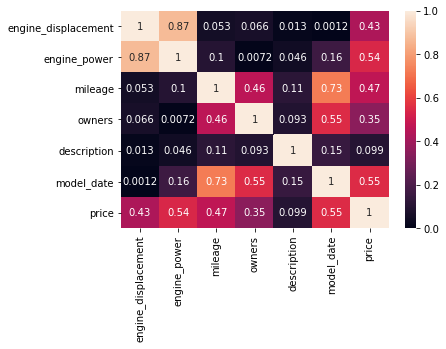

In [24]:
n_cols = num_col.copy()
n_cols.append('price')
sns.heatmap(df[df['test'] == 0][n_cols].corr().abs(),
            vmin=0, vmax=1, annot=True)

Отмечаем наличие прямой зависимости между целевой переменной и мощностью двигателя, пробегом, объемом двигателя - по жизни действительно эти факторы наиболее сильно влияют на цену автомобиля;

Между собой сильно коррелируют признаки - мощность и объем двигателя, что неудивительно;

а также наблюдается зависимость между пробегом и датой выпуска; датой выпуска и количеством владельцев.

Оценим значимость числовых признаков

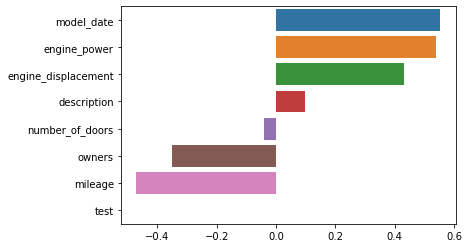

In [25]:
X_train = df[df['test'] == 0].drop('price', axis=1)
y_train = df[df['test'] == 0]['price']
correlations = X_train.corrwith(y_train).sort_values(ascending=False)
plot = sns.barplot(y=correlations.index, x=correlations)

наиболее значимые признаки, позитивно влияющие на цену -дата выпуска, мощность двигателя, объем двигателя, негативно влияющие на цену -  пробег и количество владельцев

#### Добавим новые признаки возведя в квадрат пробег, объем двигателя и его мощность для того, что бы усилить не линейное влияние этих признаков при обучении модели.

In [26]:
for col in ['engine_displacement', 'engine_power', 'mileage']:
    name = col + '_x2'
    df[name] = df[col].pow(2)
    num_col.append(name)

еще раз оценим корреляцию

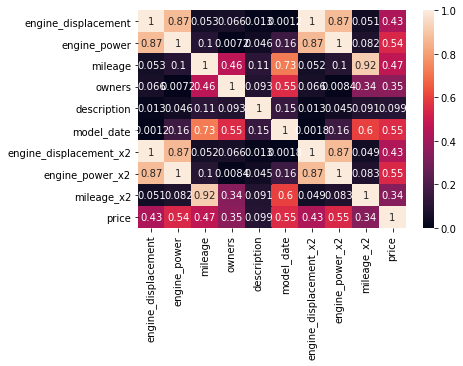

In [27]:
n_cols = num_col.copy()
n_cols.append('price')
sns.heatmap(df[df['test'] == 0][n_cols].corr().abs(),
            vmin=0, vmax=1, annot=True)

Исследуем категориальные признаки

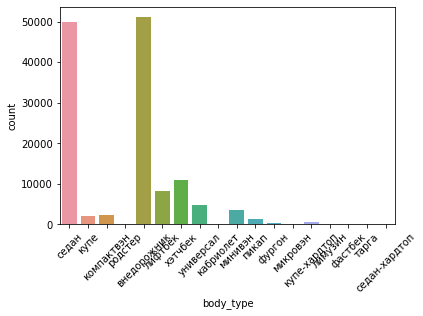

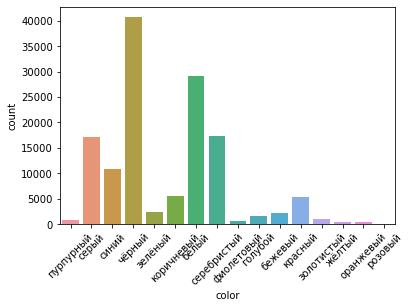

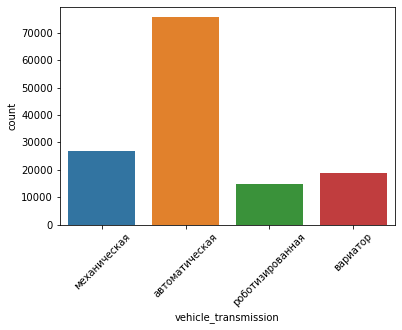

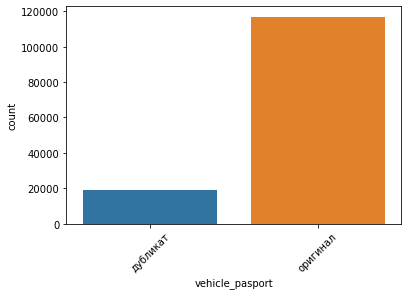

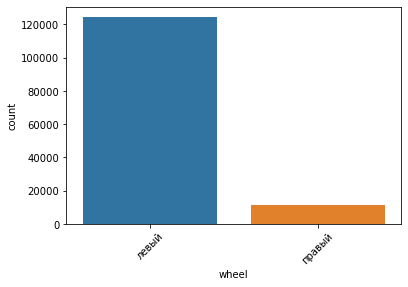

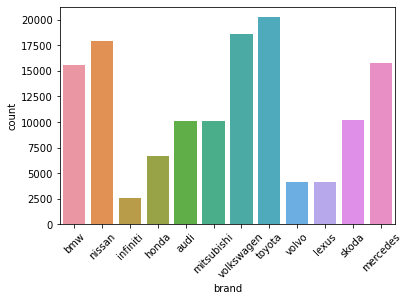

In [28]:
for col in ['body_type', 'color', 'vehicle_transmission', 'vehicle_pasport', 'wheel', 'brand']:
    ax = sns.countplot(x=col, data=df)
    ax.xaxis.set_tick_params(rotation=45)
    plt.show()

In [29]:
df.model_name.value_counts()

OCTAVIA         4895
POLO            4147
CAMRY           3814
5ER             3249
E_KLASSE        3205
                ... 
MEGA_CRUISER       1
280ZX              1
PIXO               1
V8                 1
PIXIS_JOY          1
Name: model_name, Length: 624, dtype: int64

Признак Наименование модели содержит большое количество наименований - 624
Всвязи с большим разнообразием наименований моделей, преобразуем их.
1% наименее используемый обозначим как имя бренда.

In [30]:
model_lst = []
for brand in df['brand'].unique():
    count_brand = df[df['brand'] == brand]['price'].count()
    for model in df[df['brand'] == brand]['model_name'].unique():
        count_model = df[df['model_name'] == model]['price'].count()
        if count_model/count_brand < 0.01:
            model_lst.append(model)

for model in model_lst:
    try:
        df.loc[df['model_name'] == model,
               'model_name'] = df[df['model_name'] == model]['brand'].unique()[0]
    except:
        pass

In [31]:
df.model_name.value_counts()
#  количество моделей уменьшилось до 170

OCTAVIA     4895
toyota      4685
POLO        4147
CAMRY       3814
5ER         3249
            ... 
infiniti      47
Q70           44
V70           42
XC40          41
QX4           30
Name: model_name, Length: 170, dtype: int64

Теперь оценим значимость категориальных признаков. Для этого нужно преобразовать их в числовые значения.
Для начала используем LabelEncoder для преобразования категориальных признаков в числовые значения, предварительно скопировав в новый датафрейм.

In [32]:
df_copy = df[df['test'] == 0][['body_type', 'color', 'vehicle_transmission',
                               'vehicle_pasport', 'wheel', 'brand', 'model_name', 'number_of_doors', 'price']]

label_encoder = LabelEncoder()

for column in cat_col:
    df_copy[column] = label_encoder.fit_transform(df_copy[column])

# убедимся в преобразовании
df_copy.sample(2)

,body_type,color,vehicle_transmission,vehicle_pasport,wheel,brand,model_name,number_of_doors,price
9903,11,15,0,1,0,1,4,1,2189000
20415,0,11,1,1,0,7,155,1,1250000


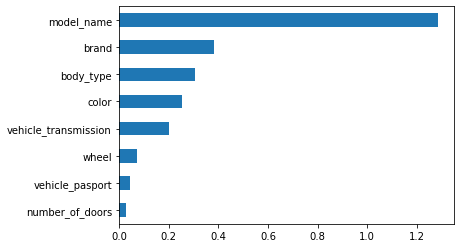

In [33]:
X_train = df_copy.drop('price', axis=1)
y_train = df_copy['price']

imp_cat = pd.Series(mutual_info_classif(X_train, y_train,
                                        discrete_features=True), index=X_train.columns)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

Из категориальных признаков наибольшее влияние на стоимость оказывают модель, брэнд, тип кузова, цвет и тип коробки передач. Наименьшее - место расположения руля, наличие оригинала/дубликата птс, количество дверей.

#### Переходим к машинному обучению

In [34]:
# преобразуем категориальные признаки
dummies = pd.get_dummies(df[cat_col])
df = df.drop(cat_col, axis=1).join(dummies)
df.sample(3)

,price,engine_displacement,engine_power,mileage,owners,description,model_date,test,engine_displacement_x2,engine_power_x2,...,model_name_honda,model_name_infiniti,model_name_lexus,model_name_mercedes,model_name_mitsubishi,model_name_nissan,model_name_skoda,model_name_toyota,model_name_volkswagen,model_name_volvo
118565,0,7.601402,5.273000,35700,1,0,2016,1,57.781317,27.804524,...,0,0,0,0,0,0,0,0,0,0
13692,690000,8.294300,5.598422,108000,1,0,2005,0,68.795406,31.342328,...,0,0,0,0,0,0,0,0,0,0
93181,860000,7.496097,5.056246,145000,3,0,2010,0,56.191475,25.565622,...,0,0,0,0,0,0,0,0,0,0


In [35]:
# разделим выборку на тренировочную и тестовую
X = df[df['test'] == 0].drop(['price'], axis=1)
X = X.drop('test', axis=1)
y = df[df['test'] == 0]['price'].values

test_df = df[df['test'] == 1].drop(['test', 'price'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, shuffle=True, random_state=42, test_size=0.2)

In [36]:
scaller = StandardScaler()

X_train_transformed = X_train.copy()
X_train_transformed[num_col] = scaller.fit_transform(
    X_train_transformed[num_col])

X_test_transformed = X_test.copy()
X_test_transformed[num_col] = scaller.transform(X_test_transformed[num_col])

test_df_transformed = test_df.copy()
test_df_transformed[num_col] = scaller.transform(test_df_transformed[num_col])

y_train_log = np.log(y_train+1)


# Выборка, включающая все данные (и трейн, и тест)
X_transformed = X.copy()
X_transformed[num_col] = scaller.transform(X_transformed[num_col])

y_log = np.log(y+1)

In [37]:
"""
# Линейная регрессия на признаках, которые не подвергались логарифмированию:
lr = LinearRegression()
print('Исследуем линейную регрессию')

mape = learn_model(lr, X_transformed, X_test_transformed, y, y_test)
predict_test, predict_submission = model_prediction(
    lr, X_test_transformed, test_df_transformed)
# Средняя абсолютная ошибка в процентах: 44.89%
# линейная регрессия показывает неутешительные результаты, алгоритм нам не подходит

"""

Исследуем линейную регрессию
Средняя абсолютная ошибка в процентах: 44.89%


In [38]:
"""
# линейная регрессия с прологарифмированными значениями
mape = learn_model(lr, X_transformed, X_test_transformed, y_log, y_test, True)
predict_test, predict_submission = model_prediction(
    lr, X_test_transformed, test_df_transformed, True)
# Средняя абсолютная ошибка в процентах: 14.75%
# логарифмирование параметров далет гораздо лучший результат

"""

Средняя абсолютная ошибка в процентах: 14.75%


<ipython-input-7-28c39a387ad3>:46: RuntimeWarning: overflow encountered in exp
  np.exp(model.predict(test_df))/rate_coeff, -3).astype(int)


In [39]:
"""
# логистическая регрессия (без логарифмирования)
logreg = LogisticRegression(max_iter=100)

mape = learn_model(logreg, X_transformed, X_test_transformed, y, y_test)
predict_test, predict_submission = model_prediction(logreg, X_test_transformed, test_df_transformed)


# не хватило мощности компьютера вполнить этот алгоритм
"""

KeyboardInterrupt: 

In [40]:
# случайный лес (без логарифмирования)
rf = RandomForestRegressor(random_state = RANDOM_SEED, n_jobs = -1, verbose = 1)

mape = learn_model(rf, X_transformed, X_test_transformed, y, y_test)
predict_test, predict_submission = model_prediction(rf, X_test_transformed, test_df_transformed)
#Средняя абсолютная ошибка в процентах: 4.40%
# случайный лес уже гораздо лучше отработал по сравнению с линейной регрессией

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   34.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s


Средняя абсолютная ошибка в процентах: 4.40%


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished


In [41]:
# случайный лес с логарифмированием
mape = learn_model(rf, X_transformed, X_test_transformed, y_log, y_test, True)
predict_test, predict_submission = model_prediction(rf, X_test_transformed, test_df_transformed, True)
# Средняя абсолютная ошибка в процентах: 4.22%
# логарифмирование параметров позволяет получить меньшую ошибку

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   37.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s


Средняя абсолютная ошибка в процентах: 4.22%


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished


In [42]:
"""

# градиентный бустинг
gb = GradientBoostingRegressor(min_samples_split=2, learning_rate=0.03, max_depth=10, n_estimators=300)

mape = learn_model(gb, X_transformed, X_test_transformed, y_log, y_test, True)
predict_test, predict_submission = model_prediction(gb, X_transformed, test_df_transformed, True)
# Средняя абсолютная ошибка в процентах: 9.22%

"""

Средняя абсолютная ошибка в процентах: 9.22%


In [45]:
"""
# XGBRegressor
xgb = XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5, learning_rate=0.03,
                   max_depth=12, reg_alpha=1.5, n_jobs=-1, n_estimators=500)

mape = learn_model(xgb, X_transformed, X_test_transformed, y_log, y_test, True)
predict_test, predict_submission = model_prediction(
    xgb, X_transformed, test_df_transformed, True)

# Средняя абсолютная ошибка в процентах: 9.86%

"""

Средняя абсолютная ошибка в процентах: 9.86%


In [48]:
"""

xb = XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5, learning_rate=0.03, \
                      max_depth=12, reg_lambda=1.5, n_jobs=-1, n_estimators=500)
mape = learn_model(xb, X_transformed, X_test_transformed, y_log, y_test, True)
predict_test, predict_submission = model_prediction(xb, X_test_transformed, test_df_transformed, True)

#Средняя абсолютная ошибка в процентах: 8.86%

"""

Средняя абсолютная ошибка в процентах: 8.86%


In [49]:
# CatBoostRegressor
cbr = CatBoostRegressor(iterations=5000, learning_rate=1,
                        depth=2, random_seed=RANDOM_SEED)

mape = learn_model(cbr, X_transformed, X_test_transformed, y_log, y_test, True)
predict_test, predict_submission = model_prediction(
    cbr, X_transformed, test_df_transformed, True)
# Средняя абсолютная ошибка в процентах: 9.94%

0:	learn: 0.5138537	total: 69.3ms	remaining: 5m 46s
1:	learn: 0.4489756	total: 74ms	remaining: 3m 4s
2:	learn: 0.4194614	total: 78.4ms	remaining: 2m 10s
3:	learn: 0.3876691	total: 82.3ms	remaining: 1m 42s
4:	learn: 0.3591240	total: 86ms	remaining: 1m 25s
5:	learn: 0.3452788	total: 89.7ms	remaining: 1m 14s
6:	learn: 0.3337732	total: 93.7ms	remaining: 1m 6s
7:	learn: 0.3226528	total: 97.9ms	remaining: 1m 1s
8:	learn: 0.3109925	total: 102ms	remaining: 56.7s
9:	learn: 0.3010841	total: 107ms	remaining: 53.3s
10:	learn: 0.2936992	total: 111ms	remaining: 50.5s
11:	learn: 0.2846437	total: 116ms	remaining: 48.4s
12:	learn: 0.2796040	total: 121ms	remaining: 46.5s
13:	learn: 0.2759525	total: 126ms	remaining: 44.9s
14:	learn: 0.2720771	total: 131ms	remaining: 43.5s
15:	learn: 0.2690911	total: 136ms	remaining: 42.3s
16:	learn: 0.2642996	total: 141ms	remaining: 41.4s
17:	learn: 0.2608498	total: 146ms	remaining: 40.4s
18:	learn: 0.2574782	total: 151ms	remaining: 39.6s
19:	learn: 0.2551732	total: 156m

Стекинг

In [118]:
# рассчёт алгоритма
def compute_meta_feature(regr, X_train, X_test, y_train, test_df, cv):
    X_meta_train = np.zeros_like(y_train, dtype=np.float32)

    splits = cv.split(X_train)
    print(splits)
    for train_fold_index, predict_fold_index in splits:
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]

        folded_regr = clone(regr)
        folded_regr.fit(X_fold_train, y_fold_train)

        X_meta_train[predict_fold_index] = folded_regr.predict(X_fold_predict)

    meta_regr = clone(regr)
    meta_regr.fit(X_train, y_train)

    X_meta_test = meta_regr.predict(X_test)
    X_meta_pred = meta_regr.predict(test_df)

    return X_meta_train, X_meta_test, X_meta_pred

In [119]:
def generate_meta_features(regr, X_train, X_test, y_train, test_df, cv):
    features = [compute_meta_feature(
        regr, X_train, X_test, y_train, test_df, cv) for regr in tqdm(regr)]
    stacked_features_train = np.vstack(
        [features_train for features_train, features_test, features_pred in features]).T
    stacked_features_test = np.vstack(
        [features_test for features_train, features_test, features_pred in features]).T
    stacked_features_pred = np.vstack(
        [features_pred for features_train, features_test, features_pred in features]).T
    return stacked_features_train, stacked_features_test, stacked_features_pred

In [120]:
cv = KFold(n_splits=10, shuffle=True, random_state=42)


def compute_metric(clf, X_train=X_train, y_train=y_train, X_test=X_test):
    clf.fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)
    return np.round(f1_score(y_test, y_test_pred, average='macro'), 6)

Список моделей для стекинга

In [121]:
# выбраем базовые модели
models = [
    RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1),
    ExtraTreesRegressor(n_estimators=300,
                        criterion='mse',
                        bootstrap=True,
                        n_jobs=-1,
                        random_state=RANDOM_SEED
                        ),
    XGBRegressor(objective='reg:squarederror',
                 n_estimators=300,
                 colsample_bytree=0.5,
                 learning_rate=0.03,
                 max_depth=12,
                 reg_alpha=1.5,
                 n_jobs=-1
                 ),
    XGBRegressor(objective='reg:squarederror',
                 n_estimators=300,
                 colsample_bytree=0.5,
                 learning_rate=0.03,
                 max_depth=12,
                 reg_lambda=1.5,
                 n_jobs=-1
                 )
]

In [129]:
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

# обучаем базовые модели, на выходе получаем сгенерированные параметры, которые будут являться входом для мета-модели

stacked_features_train, stacked_features_test, stacked_features_pred = generate_meta_features(
    models, X_transformed.values, X_test_transformed.values, y_log, test_df_transformed.values, cv)




  0%|          | 0/4 [00:00<?, ?it/s]

<generator object _BaseKFold.split at 0x7fe49d1e8d60>


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   37.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   37.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
  0%|          | 0/4 [11:42<?, ?it/s]
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34

<generator object _BaseKFold.split at 0x7fe49d1d6120>





 50%|█████     | 2/4 [14:25<11:50, 355.34s/it]

<generator object _BaseKFold.split at 0x7fe49d1e8890>





 75%|███████▌  | 3/4 [25:36<07:30, 450.12s/it]

<generator object _BaseKFold.split at 0x7fe49d1e85f0>





100%|██████████| 4/4 [37:09<00:00, 557.27s/it]


In [134]:
# Используем в качестве мета модели линейную регрессию с дефолтными параметрами
lr = LinearRegression()
mape = learn_model(lr, stacked_features_train,
                   stacked_features_test, y_log, y_test, True)
predict_test, predict_submission = model_prediction(
    lr, stacked_features_test, stacked_features_pred, True)

Средняя абсолютная ошибка в процентах: 6.87%


In [135]:
# Используем Случайный лес в качестве мета-модели
rf = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1)
mape = learn_model(rf, stacked_features_train,
                   stacked_features_test, y_log, y_test, True)
predict_test, predict_submission = model_prediction(
    rf, stacked_features_test, stacked_features_pred, True)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s


Средняя абсолютная ошибка в процентах: 7.59%


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished


In [140]:
# Градиентный бустинг в качестве мета-модели
gb_s = GradientBoostingRegressor(
    min_samples_split=2, learning_rate=0.03, max_depth=10, n_estimators=300)


mape = learn_model(gb_s, stacked_features_train,
                   stacked_features_test, y_log, y_test, True)
predict_test, predict_submission = model_prediction(
    gb_s, stacked_features_test, stacked_features_pred, True)

# Средняя абсолютная ошибка в процентах: 4.46%

Средняя абсолютная ошибка в процентах: 4.46%


Попробуем другой состав стекинга

In [136]:
models = [
    RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1),
    ExtraTreesRegressor(n_estimators=200, min_samples_split=2,
                        max_depth=None, bootstrap=True)
]

cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

stacked_features_train, stacked_features_test, stacked_features_pred = generate_meta_features(
    models, X_transformed.values, X_test_transformed.values, y_log, test_df_transformed.values, cv)



lr = LinearRegression()
mape = learn_model(lr, stacked_features_train,
                   stacked_features_test, y_log, y_test, True)
predict_test, predict_submission = model_prediction(
    lr, stacked_features_test, stacked_features_pred, True)

  0%|          | 0/2 [00:00<?, ?it/s]

<generator object _BaseKFold.split at 0x7fe49d1f47b0>


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   35.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   38.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.1s
[Parall

<generator object _BaseKFold.split at 0x7fe49aee3f20>


100%|██████████| 2/2 [19:06<00:00, 573.04s/it]

Средняя абсолютная ошибка в процентах: 4.10%


In [142]:
test_submission = pd.read_csv('sample_submission.csv')
test_submission

,sell_id,price
0,1100575026,0
1,1100549428,0
2,1100658222,0
3,1100937408,0
4,1101037972,0
...,...,...
34681,1101369263,0
34682,1101369581,0
34683,1101364889,0
34684,1101362518,0


In [145]:
predict = np.around(predict_submission).astype(int)
test_submission['price'] = predict
test_submission.to_csv('submission_1.csv', index=False)

Сравнив поулчившиеся значения mape неплохо себя показали:

Стекинг (базовые модели: RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1),
    ExtraTreesRegressor(n_estimators=200, min_samples_split=2,
                        max_depth=None, bootstrap=True), мета-модель: линейная регрессия с дефолтными параметрами), mape - 4,10%
                        
Cлучайный лес с логарифмированием, mape - 4.22%
